<a href="https://colab.research.google.com/github/GarganoNicolas/timeSeries1_codificandobits/blob/main/timeSeries1_codificandobits_lstm_timeseries_multivariado_unistep.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#*FORECASTING* CON REDES LSTM - PARTE 4: MODELO MULTIVARIADO - UNISTEP

## Contenido

1. [Introducción](#scrollTo=wHQ1yXwrk6CN)
2. [El set de datos](#scrollTo=QDm0J6L-7rGI&line=1&uniqifier=1)
3. [El problema a resolver](#scrollTo=CBJV_YRvj5CZ&line=1&uniqifier=1)
4. [Lectura del set de datos](#scrollTo=Es6L4nEckb3S&line=1&uniqifier=1)
5. [*Feature engineering*](#scrollTo=Ex5fnN-tMD7c&line=25&uniqifier=1)
6. [Pre-procesamiento](#scrollTo=vd5lyqNrlfFg)
7. [Creación y entrenamiento del modelo](#scrollTo=016D9eVw3Beb)
8. [Desempeño del modelo](#scrollTo=ZkI9vr5S69i_)
9. [Predicciones con el modelo entrenado](#scrollTo=fvqk4f8L3aXE&line=1&uniqifier=1)
10. [Conclusiones y sugerencias](#scrollTo=0AFY2trj_KLo&line=1&uniqifier=1)

## 1. Introducción

En los videos anteriores hemos visto como realizar el pre-procesamiento de los datos y cómo implementar los dos primeros tipos de modelos predictivos usando los enfoques univariado-unistep y univariado-multistep.

En este video veremos el tercer tipo de modelo predictivo, en donde en lugar de una usaremos múltiples variables de entrada a la Red LSTM para predecir una sola variable y un sólo instante de tiempo. Así que nos enfocaremos en el modelo multivariado + uni-step.

De nuevo aprovecharemos el código implementado anteriormente para, con sólo algunas modificaciones, lograr implementar la Red LSTM capaz de generar este tipo de predicciones, aunque en este caso añadiremos un paso adicional: algo que se conoce como **ingeniería de características o *feature engineering***.

##2. El set de datos

Recordemos que estamos usando el  [weather dataset](https://www.bgc-jena.mpg.de/wetter/weather_data.html), un set de datos que contiene el registro histórico de 14 diferentes variables climáticas en el período entre 2009 y 2015.

En el segundo video de la serie realizamos el análisis exploratorio del dataset y realizamos este pre-procesamiento:

1. Hicimos el manejo de datos faltantes
2. Verificamos que el dataset no tuviese valores extremos
3. Re-interpolamos el dataset para garantizar una periodicidad de 1 hora

Este será el set de datos que usaremos en este tutorial.

##3. El problema a resolver

Crear y entrenar una Red LSTM usando el enfoque multivariado + uni-step:

![](https://drive.google.com/uc?export=view&id=1uq-buHEizcVfR5grXnSrMnwdfgNEzXMf)

En este caso tomaremos como entrada al modelo las 14 covariables disponibles en el dataset (de ahí el término multivariado) y a la salida intentaremos predecir 1 hora de temperatura a futuro (de ahí el término uni-step).

Específicamente tendremos que modificar en nuestro código:

1. **El pre-procesamiento** para crear el dataset supervisado con el número de covariables requerido a la entrada del modelo
2. **La Red LSTM**, que en lugar de una sola ahora deberá aceptar 14 variables de entrada (cada una con un registro de 24 horas).

##4. Lectura del set de datos

Recordemos que usaremos el dataset implementado en el [segundo video de la serie](https://youtu.be/R8MEPGn9sFI), sobre el cual ya hemos hecho un pre-procesamiento previo:

In [1]:
from google.colab import drive
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Leer set de datos
ruta = 'https://raw.githubusercontent.com/GarganoNicolas/timeSeries1_codificandobits/main/weather_dataset_preprocesado.csv'
df = pd.read_csv(ruta, index_col='datetime')
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
datetime,,,,,,,,,,,,,,
2009-01-01 01:00:00,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
2009-01-01 02:00:00,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2009-01-01 03:00:00,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
2009-01-01 04:00:00,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
2009-01-01 05:00:00,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2014-09-24 12:00:00,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1
2014-09-24 13:00:00,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0
2014-09-24 14:00:00,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5


En este caso **NO** incluiremos la variable tiempo como una covariable, así que podremos eliminarla:

In [2]:
df = df.reset_index()
df = df.drop(columns=['datetime'])
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,0.21,0.63,192.7
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,0.25,0.63,190.3
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,0.18,0.63,167.2
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,0.10,0.38,240.0
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,0.40,0.88,157.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,2.92,4.00,174.1
50220,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,1.57,2.48,173.0
50221,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,2.79,4.75,202.5
50222,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,2.86,4.32,172.0


## 5. *Feature engineering*

En lugar de alimentar al modelo con los datos en bruto, aprovecharemos la relación existente entre algunas covariables para obtener una representación equivalente de las mismas.

Este proceso de tomar las covariables en bruto, procesarlas y modificarlas para generar nuevas características que alimenten el modelo se conoce como ingeniería de características.

En este caso nos enfocaremos sólo en las variables relacionadas con el viento:

1. `wv (m/s)`: velocidad del viento (en m/s)
2. `wd (deg)`: dirección del viento (en grados)
3. `max. wv (m/s)`: velocidad del viento máxima (en m/s)

En este caso optaremos por:

1. Eliminar `max. wv (m/s)` (pues resulta redundante, teniendo en cuenta que existe la covariable `wv (m/s)`)
2. Combinar `wv (m/s)` y `wd (deg)` usando una representación vectorial

![](https://drive.google.com/uc?export=view&id=1S9eqcTPkVTqcGKt-Z2GxDp7c-JKZNH41)

donde:

- $W_x = wv \cdot cos(wd)$
- $W_y = wv \cdot sin(wd)$

Este *feature engineering* hará que en lugar de 14 sean 13 las covariables que presentaremos al modelo:

In [3]:
# Feature engineering
w_dir = df['wd (deg)']*np.pi/180
Wx = df['wv (m/s)']*np.cos(w_dir)
Wy = df['wv (m/s)']*np.sin(w_dir)

# Eliminar columnas irrelevantes
df.pop('wd (deg)')
df.pop('wv (m/s)')
df.pop('max. wv (m/s)')

# E incluir las columnas de interés
df['Wx'] = Wx
df['Wy'] = Wy
df

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),Wx,Wy
0,996.50,-8.05,265.38,-8.78,94.40,3.33,3.14,0.19,1.96,3.15,1307.86,-0.204862,-0.046168
1,996.62,-8.88,264.54,-9.77,93.20,3.12,2.90,0.21,1.81,2.91,1312.25,-0.245971,-0.044701
2,996.84,-8.81,264.59,-9.66,93.50,3.13,2.93,0.20,1.83,2.94,1312.18,-0.175527,0.039879
3,996.99,-9.05,264.34,-10.02,92.60,3.07,2.85,0.23,1.78,2.85,1313.61,-0.050000,-0.086603
4,997.46,-9.63,263.72,-10.65,92.20,2.94,2.71,0.23,1.69,2.71,1317.19,-0.368202,0.156292
...,...,...,...,...,...,...,...,...,...,...,...,...,...
50219,987.01,13.69,287.92,6.29,60.85,15.69,9.55,6.14,6.04,9.67,1194.28,-2.904532,0.300154
50220,986.55,14.19,288.47,6.80,61.01,16.21,9.89,6.32,6.26,10.02,1191.48,-1.558297,0.191335
50221,986.21,14.99,289.30,6.70,57.54,17.07,9.82,7.25,6.22,9.96,1187.80,-2.577624,-1.067687
50222,984.76,15.20,289.63,6.96,57.79,17.30,10.00,7.30,6.34,10.15,1185.10,-2.832167,0.398035


##6. Pre-procesamiento

Implica:

1. Partición en train/val/test (80%, 10%, 10%).
2. Generación del dataset supervisado: entrada y salida del modelo
3. Escalamiento

En cada una de estas fases usaremos prácticamente el mismo código usado en los modelos univariados pero con algunas ligeras modificaciones.

### 6.1. Partición del set en entrenamiento, validación y prueba

A diferencia de otros modelos de Machine Learning, en el caso de series de tiempo **se debe garantizar que se generan las particiones sin mezclar aleatoriamente los datos**.

Recordemos además que:
- El set de entrenamiento (*train*) se usará para encontrar los parámetros del modelo
- El set de validación (*val*) para verificar que no haya *under/over-fitting* del modelo y para ajustar sus hiperparámetros
- El set de prueba (*test*) para poner a prueba el mejor modelo encontrado durante el entrenamiento/validación

En este caso usaremos la misma función implementada para los modelos univariados con la diferencia de que en lugar de introducir una *serie* de Pandas, introduciremos el *DataFrame* completo.

Por tanto, la función retornará tres *dataframes* (train, val y test):

In [4]:
# Función para generar las particiones preservando las características
# de la serie de tiempo

def train_val_test_split(dataframe, tr_size=0.8, vl_size=0.1, ts_size=0.1 ):
    # Definir número de datos en cada subserie
    N = dataframe.shape[0]
    Ntrain = int(tr_size*N)  # Número de datos de entrenamiento
    Nval = int(vl_size*N)    # Número de datos de validación
    Ntst = N - Ntrain - Nval # Número de datos de prueba

    # Realizar partición
    train = dataframe[0:Ntrain]
    val = dataframe[Ntrain:Ntrain+Nval]
    test = dataframe[Ntrain+Nval:]

    return train, val, test

# Prueba de la función
tr, vl, ts = train_val_test_split(df)

print(f'Tamaño set de entrenamiento: {tr.shape}')
print(f'Tamaño set de validación: {vl.shape}')
print(f'Tamaño set de prueba: {ts.shape}')

Tamaño set de entrenamiento: (40179, 13)
Tamaño set de validación: (5022, 13)
Tamaño set de prueba: (5023, 13)


Observemos que en lugar de una columna cada subset tiene ahora 13 (correspondientes a las covariables).

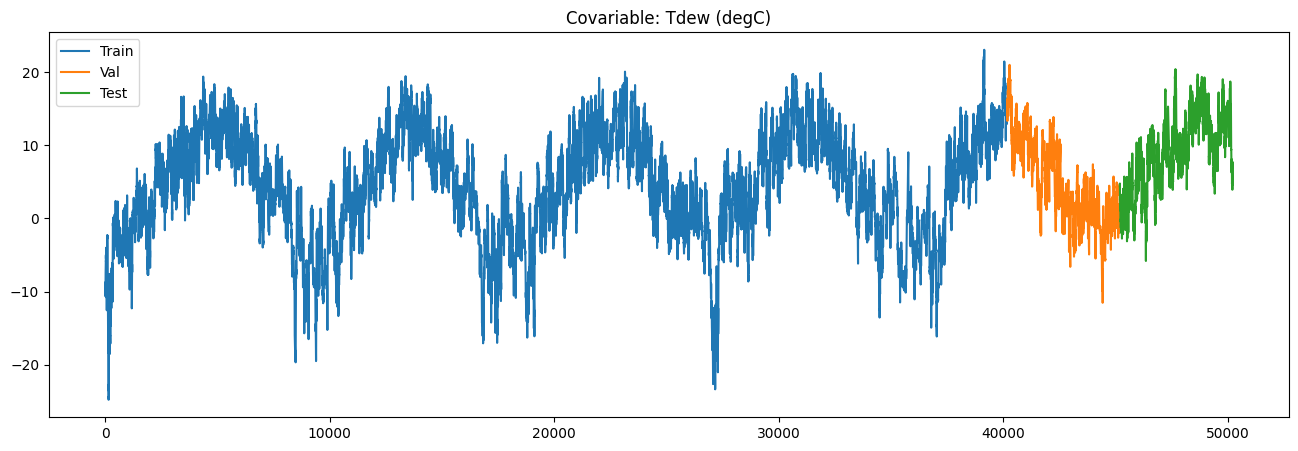

In [7]:
covar = 3 # Índice de la covariable (columna del dataset) a graficar
col = df.columns[covar]

# Dibujar los sets de entrenamiento/validación/prueba para la covariable
fig, ax = plt.subplots(figsize = (16,5))
ax.plot(tr[col], label='Train')
ax.plot(vl[col], label='Val')
ax.plot(ts[col], label='Test')
ax.set_title(f'Covariable: {col}')
plt.legend();

###6.2 Generación del dataset supervisado (entrada y salida del modelo)

Debemos ajustar nuestro set de datos de acuerdo a lo especificado en la [documentación de las Redes LSTM en TensorFlow/Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTM):

![](https://drive.google.com/uc?export=view&id=1SCdS0c9N7z5zhg6YxxY3rSSvphAFO83P)

Así que en este caso cada dato de entrenamiento será:

- Un arreglo de 24 (horas) x 13 (features) correspondiente a la entrada
- Un arreglo de 1 (hora) x 1 (feature) correspondiente a la hora 25 (a predecir):

![](https://drive.google.com/uc?export=view&id=1SDF_aecVSZLoD6-bfsp55m7u09h2ysrk)

Como en los casos anteriores, el parámetro  `INPUT_LENGTH` se convierte en un hiperparámetro que terminará afectando el desempeño de la Red LSTM al momento de hacer las predicciones.

Y usaremos la misma función usada en los tutoriales anteriores:

In [8]:
def crear_dataset_supervisado(array, input_length, output_length):
    '''Permite crear un dataset con las entradas (X) y salidas (Y)
    requeridas por la Red LSTM.

    Parámetros:
    - array: arreglo numpy de tamaño N x features (N: cantidad de datos,
      f: cantidad de features)
    - input_length: instantes de tiempo consecutivos de la(s) serie(s) de tiempo
      usados para alimentar el modelo
    - output_length: instantes de tiempo a pronosticar (salida del modelo)
    '''

    # Inicialización
    X, Y = [], []    # Listados que contendrán los datos de entrada y salida del modelo
    shape = array.shape
    if len(shape)==1: # Si tenemos sólo una serie (univariado)
        fils, cols = array.shape[0], 1
        array = array.reshape(fils,cols)
    else: # Multivariado <-- <--- ¡esta parte de la función se ejecuta en este caso!
        fils, cols = array.shape

    # Generar los arreglos
    for i in range(fils-input_length-output_length):
        # Entrada al modelo
        X.append(array[i:i+INPUT_LENGTH,0:cols])

        # Salida (el índice 1 corresponde a la columna con la variable a predecir)
        Y.append(array[i+input_length:i+input_length+output_length,1].reshape(output_length,1))

    # Convertir listas a arreglos de NumPy
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [9]:
# Crear los datasets de entrenamiento, prueba y validación y verificar sus tamaños
INPUT_LENGTH = 24    # Hiperparámetro
OUTPUT_LENGTH = 1    # Modelo uni-step

x_tr, y_tr = crear_dataset_supervisado(tr.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_vl, y_vl = crear_dataset_supervisado(vl.values, INPUT_LENGTH, OUTPUT_LENGTH)
x_ts, y_ts = crear_dataset_supervisado(ts.values, INPUT_LENGTH, OUTPUT_LENGTH)

# Imprimir información en pantalla
print('Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)')
print(f'Set de entrenamiento - x_tr: {x_tr.shape}, y_tr: {y_tr.shape}')
print(f'Set de validación - x_vl: {x_vl.shape}, y_vl: {y_vl.shape}')
print(f'Set de prueba - x_ts: {x_ts.shape}, y_ts: {y_ts.shape}')

Tamaños entrada (BATCHES x INPUT_LENGTH x FEATURES) y de salida (BATCHES x OUTPUT_LENGTH x FEATURES)
Set de entrenamiento - x_tr: (40154, 24, 13), y_tr: (40154, 1, 1)
Set de validación - x_vl: (4997, 24, 13), y_vl: (4997, 1, 1)
Set de prueba - x_ts: (4998, 24, 13), y_ts: (4998, 1, 1)


###6.3 Escalamiento

Es requerido para garantizar que todas las características se encuentran en el mismo rango de valores, lo que facilita el entrenamiento del modelo y las predicciones.

En comparación con entradas univariadas, en este caso por tener múltiples variables de entrada se requiere escalar cada una de ellas a la entrada del modelo. Por tanto se creará un total de 13 escaladores (1 por cada covariable).

Sin embargo, a la salida del modelo seguiremos teniendo sólo 1 variable a predecir (la temperatura) y por tanto sólo es necesario escalar dicha variable en el arreglo *Y* de salida:

In [10]:
from sklearn.preprocessing import MinMaxScaler

def escalar_dataset(data_input, col_ref):
    '''Escala el dataset en el rango de -1 a 1.

    Entradas:
    - data_input: diccionario con los dataset de entrada y salida del modelo
    (data_input = {'x_tr':x_tr, 'y_tr':y_tr, 'x_vl':x_vl, 'y_vl':y_vl,
                    'y_ts':y_ts})
    - col_ref: parámetro adicional para especificar la columna que contiene
      la variable a predecir


    Retorna:
    - data_scaled: diccionario con los datasets de entrada y salida escalados
      (tiene la misma estructura del diccionario de entrada)
    - scaler: el escalador usado (requerido para las predicciones)
    '''

    # *** Implementación adicional: determinar el índice de la columna
    # que contiene la variable a predecir
    col_ref = df.columns.get_loc(col_ref)

    # Número de instantes de tiempo de entrada y de covariables
    NFEATS = data_input['x_tr'].shape[2]

    # Generar listado con "scalers" (1 por cada covariable de entrada)
    scalers = [MinMaxScaler(feature_range=(-1,1)) for i in range(NFEATS)]

    # Arreglos que contendrán los datasets escalados
    x_tr_s = np.zeros(data_input['x_tr'].shape)
    x_vl_s = np.zeros(data_input['x_vl'].shape)
    x_ts_s = np.zeros(data_input['x_ts'].shape)
    y_tr_s = np.zeros(data_input['y_tr'].shape)
    y_vl_s = np.zeros(data_input['y_vl'].shape)
    y_ts_s = np.zeros(data_input['y_ts'].shape)

    # Escalamiento: se usarán los min/max del set de entrenamiento para
    # escalar la totalidad de los datasets

    # Escalamiento Xs
    for i in range(NFEATS):
        x_tr_s[:,:,i] = scalers[i].fit_transform(x_tr[:,:,i])
        x_vl_s[:,:,i] = scalers[i].transform(x_vl[:,:,i])
        x_ts_s[:,:,i] = scalers[i].transform(x_ts[:,:,i])

    # Escalamiento Ys (teniendo en cuenta "col_ind")
    y_tr_s[:,:,0] = scalers[col_ref].fit_transform(y_tr[:,:,0])
    y_vl_s[:,:,0] = scalers[col_ref].transform(y_vl[:,:,0])
    y_ts_s[:,:,0] = scalers[col_ref].transform(y_ts[:,:,0])

    # Conformar diccionario de salida
    data_scaled = {
        'x_tr_s': x_tr_s, 'y_tr_s': y_tr_s,
        'x_vl_s': x_vl_s, 'y_vl_s': y_vl_s,
        'x_ts_s': x_ts_s, 'y_ts_s': y_ts_s,
    }

    return data_scaled, scalers[col_ref]

In [11]:
# Escalamiento del dataset con la función anterior

# Crear diccionario de entrada
data_in = {
    'x_tr': x_tr, 'y_tr': y_tr,
    'x_vl': x_vl, 'y_vl': y_vl,
    'x_ts': x_ts, 'y_ts': y_ts,
}

# Y escalar (especificando la columna con la variable a predecir)
data_s, scaler = escalar_dataset(data_in, col_ref = 'T (degC)' )

# Extraer subsets escalados
x_tr_s, y_tr_s = data_s['x_tr_s'], data_s['y_tr_s']
x_vl_s, y_vl_s = data_s['x_vl_s'], data_s['y_vl_s']
x_ts_s, y_ts_s = data_s['x_ts_s'], data_s['y_ts_s']

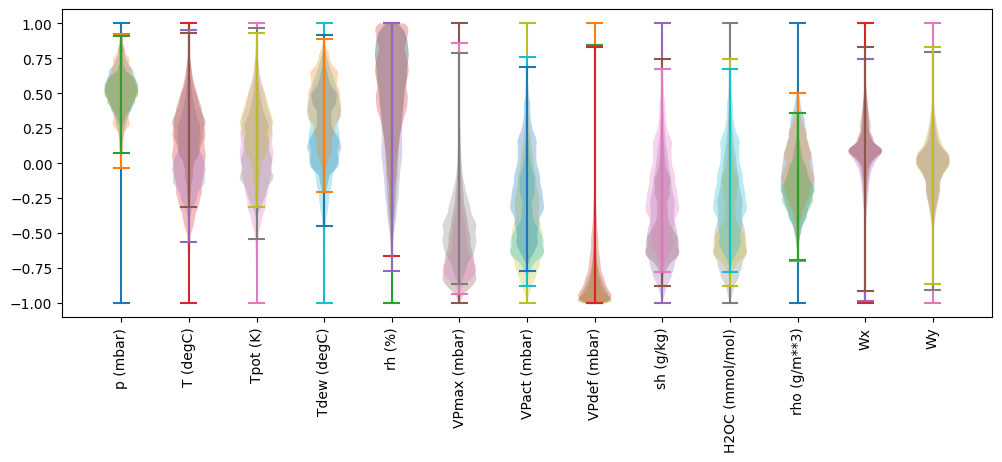

In [12]:
# Y generemos una gráfica tipo violín para ver la distribución
# de los valores en cada covariable (entrada) y en la variable a
# predecir (salida)

fig, ax = plt.subplots(figsize=(12,4))
for i in range(13):
    ax.violinplot(dataset=x_tr_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_vl_s[:,:,i].flatten(), positions=[i])
    ax.violinplot(dataset=x_ts_s[:,:,i].flatten(), positions=[i])

# Etiquetas eje horizontal
ax.set_xticks(list(range(13)))
ax.set_xticklabels(df.keys(), rotation=90)
ax.autoscale();

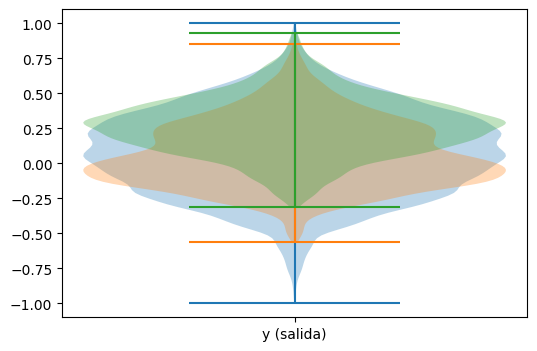

In [ ]:
# Y hagamos lo mismo con la variable de salida:
fig, ax = plt.subplots(figsize=(6,4))
ax.violinplot(dataset=y_tr_s.flatten())
ax.violinplot(dataset=y_vl_s.flatten())
ax.violinplot(dataset=y_ts_s.flatten())
ax.set_xticks([1])
ax.set_xticklabels(['y (salida)']);

##7. Creación y entrenamiento del modelo

- Entradas: arreglos *x* (batches x input-length  x features = batches x 24 x 13)
- Salidas: arreglos *y* (batches x output-length x features = batches x 1 x 1)

Usaremos la raíz cuadrada del error cuadrático medio (o RMSE por sus siglas en Inglés: *root mean square error*) como pérdida para entrenar el modelo:

$RMSE = \sqrt{\frac{\sum_i (y_i-\hat{y_i})^2}{N}}$

donde:
- $y$: temperatura real
- $\hat{y}$: temperatura predicha
- $N$: cantidad de predicciones

In [13]:
# Creación del modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
import tensorflow as tf

# Ajustar parámetros para reproducibilidad del entrenamiento
tf.random.set_seed(123)
tf.config.experimental.enable_op_determinism()

# El modelo
N_UNITS = 128 # Tamaño del estado oculto (h) y de la celdad de memoria (c) (128)
INPUT_SHAPE = (x_tr_s.shape[1], x_tr_s.shape[2]) # 24 (horas) x 13 (features)

modelo = Sequential()
modelo.add(LSTM(N_UNITS, input_shape=INPUT_SHAPE))

# Y lo único que cambia con respecto al modelo multivariado + uni-step es
# el tamaño deldato de salida
modelo.add(Dense(OUTPUT_LENGTH, activation='linear')) # activation = 'linear' pues queremos pronosticar (regresión)

# Pérdida: se usará el RMSE (root mean squared error) para el entrenamiento
# pues permite tener errores en las mismas unidades de la temperatura
def root_mean_squared_error(y_true, y_pred):
    rmse = tf.math.sqrt(tf.math.reduce_mean(tf.square(y_pred-y_true)))
    return rmse

# Compilación
optimizador = RMSprop(learning_rate=5e-4) # 5e-5
modelo.compile(
    optimizer = optimizador,
    loss = root_mean_squared_error,
)

# Entrenamiento (aproximadamente 1 min usando GPU)
EPOCHS = 80 # Hiperparámetro
BATCH_SIZE = 256 # Hiperparámetro
historia = modelo.fit(
    x = x_tr_s,
    y = y_tr_s,
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    validation_data = (x_vl_s, y_vl_s),
    verbose=2
)

Epoch 1/80
157/157 - 9s - loss: 0.0690 - val_loss: 0.0443 - 9s/epoch - 54ms/step
Epoch 2/80
157/157 - 1s - loss: 0.0387 - val_loss: 0.0316 - 731ms/epoch - 5ms/step
Epoch 3/80
157/157 - 1s - loss: 0.0334 - val_loss: 0.0259 - 866ms/epoch - 6ms/step
Epoch 4/80
157/157 - 1s - loss: 0.0307 - val_loss: 0.0271 - 883ms/epoch - 6ms/step
Epoch 5/80
157/157 - 1s - loss: 0.0290 - val_loss: 0.0280 - 841ms/epoch - 5ms/step
Epoch 6/80
157/157 - 1s - loss: 0.0279 - val_loss: 0.0238 - 832ms/epoch - 5ms/step
Epoch 7/80
157/157 - 1s - loss: 0.0272 - val_loss: 0.0247 - 714ms/epoch - 5ms/step
Epoch 8/80
157/157 - 1s - loss: 0.0267 - val_loss: 0.0268 - 700ms/epoch - 4ms/step
Epoch 9/80
157/157 - 1s - loss: 0.0265 - val_loss: 0.0233 - 670ms/epoch - 4ms/step
Epoch 10/80
157/157 - 1s - loss: 0.0262 - val_loss: 0.0257 - 670ms/epoch - 4ms/step
Epoch 11/80
157/157 - 1s - loss: 0.0259 - val_loss: 0.0238 - 666ms/epoch - 4ms/step
Epoch 12/80
157/157 - 1s - loss: 0.0257 - val_loss: 0.0233 - 679ms/epoch - 4ms/step
Epo

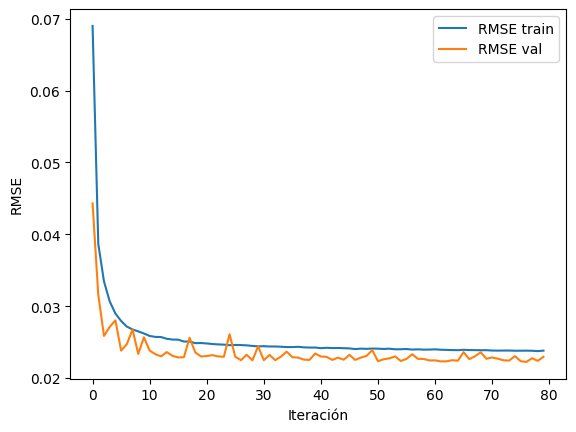

In [14]:
 # Graficar curvas de entrenamiento y validación
 # para verificar que no existe overfitting
plt.plot(historia.history['loss'],label='RMSE train')
plt.plot(historia.history['val_loss'],label='RMSE val')
plt.xlabel('Iteración')
plt.ylabel('RMSE')
plt.legend();

**Observaciones y sugerencias:**

- El modelo con entradas multivariadas parece tener un desempeño similar al obtenido con los modelos univariados (RMSEs del orden del 2%).

Para intentar mejorar el desempeño se sugiere:
- Hacer un análisis de relevancia de las variables (*feature importance*) y entrenar el modelo sólo con aquellas más relevantes.
- Afinar los hiperparámetros del modelo usando técnicas como, por ejemplo, *random grid search*:
  - *INPUT_LENGTH*
  - Número de unidades de la Red LSTM
  - Pérdida
  - Tasa de aprendizaje
  - Epochs
  - Batch size


## 8. Desempeño del modelo

Suponiendo que el modelo ya ha sido afinado y entrenado, verificaremos su desempeño para el set de prueba y lo compararemos con el desempeño obtenido con los sets de entrenamiento y validación:

In [15]:
# Cálculo de rmses para train, val y test
rmse_tr = modelo.evaluate(x=x_tr_s, y=y_tr_s, verbose=0)
rmse_vl = modelo.evaluate(x=x_vl_s, y=y_vl_s, verbose=0)
rmse_ts = modelo.evaluate(x=x_ts_s, y=y_ts_s, verbose=0)

# Imprimir resultados en pantalla
print('Comparativo desempeños:')
print(f'  RMSE train:\t {rmse_tr:.3f}')
print(f'  RMSE val:\t {rmse_vl:.3f}')
print(f'  RMSE test:\t {rmse_ts:.3f}')

Comparativo desempeños:
  RMSE train:	 0.023
  RMSE val:	 0.022
  RMSE test:	 0.025


##9. Predicciones con el modelo entrenado

Suponiendo que el modelo ya ha sido afinado, podemos ponerlo a prueba con el set *test*.

Usaremos la misma función `predecir` usada en los videos anteriores:

In [16]:
def predecir(x, model, scaler):
    '''Genera la predicción de OUTPUT_LENGTH instantes
    de tiempo a futuro con el modelo entrenado.

    Entrada:
    - x: batch (o batches) de datos para ingresar al modelo
      (tamaño: BATCHES X INPUT_LENGTH X FEATURES)
    - model: Red LSTM entrenada
    - scaler: escalador (requerido para llevar la predicción a la escala original)

    Salida:
    - y_pred: la predicción en la escala original (tamaño: BATCHES X OUTPUT_LENGTH X FEATURES)
    '''

    # Calcular predicción escalada en el rango de -1 a 1
    y_pred_s = model.predict(x,verbose=0)

    # Llevar la predicción a la escala original
    y_pred = scaler.inverse_transform(y_pred_s)

    return y_pred.flatten()

In [17]:
# Calcular predicciones sobre el set de prueba
y_ts_pred = predecir(x_ts_s, modelo, scaler)

Analicemos este desempeño gráficamente mostrando las temperaturas originales y las predichas por el modelo para cada uno de los datos en el set de prueba:

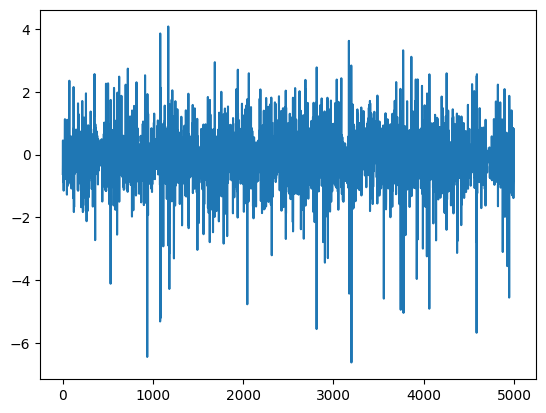

In [18]:
N = len(y_ts_pred)    # Número de predicciones
ndato = np.linspace(1,N,N)

# Cálculo de errores simples
errores = y_ts.flatten()-y_ts_pred
plt.plot(errores);

Se observa que:

- El promedio de errores es cercano a cero
- Pero en algunos instantes de tiempo se alcanzan errores extremos de hasta -6 y +5 grados.

Estos errores se podrían reducir al hacer una afinación del modelo o modificando el enfoque de predicción.

## 10. Conclusiones y sugerencias

- Hemos entrenado un tercer modelo multivariado + uni-step
- Un elemento adicional en este caso (al considerar múltiples variables de entrada) es el *feature engineering*.
- Tras analizar el desempeño del modelo vemos que este es ligeramente similar al obtenido en los videos anteriores con los modelos cuya entrada era una sola variable, aunque es necesario afinar todos los modelos para posteriormente poder comparar adecuadamente estos desempeños.

Además, en el caso de los modelos multivariados, se podría realizar lo que se conoce como **análisis de la importancia de las características** (o *feature importance*) para determinar cuáles covariables tienen un mayor impacto en la predicción.

Al determinar cuáles covariables tienen un mayor impacto se podría re-entrenar el modelo sólo con dichas covariables e intentar mejorar su desempeño.

En el próximo video veremos el último tipo de modelo más usado al momento de hacer predicciones.

Este modelo seguirá teniendo múltiples variables de entrada pero en lugar de un instante de tiempo haremos la predicción sobre múltiples instantes de tiempo.

Así que veremos cómo implementar una Red LSTM usando el enfoque multivariado + multi-step.